# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from nltk.stem import PorterStemmer
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import tensorflow
from tensorflow.keras.layers import Dense, RNN, LSTM,Embedding, MaxPooling2D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

Loading the whole data

In [2]:
train_set = pd.read_csv(r'F:\AI Diploma\New\Graduation Project\train.csv') 
test_set = pd.read_csv(r'F:\AI Diploma\New\Graduation Project\test.csv')

In [3]:
train_set.head() #print out first 5 lines of the data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
null = train_set.isna().sum()
null

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
for key in null.keys():
    print('Percentage of the Column', key,'is: ',round(null[key]/7613*100,2),'%')

Percentage of the Column id is:  0.0 %
Percentage of the Column keyword is:  0.8 %
Percentage of the Column location is:  33.27 %
Percentage of the Column text is:  0.0 %
Percentage of the Column target is:  0.0 %


In [7]:
train_set['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [8]:
train_set['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [9]:
train_set['target'].value_counts() #It seems that the target of the data is binary classification without biasing

0    4342
1    3271
Name: target, dtype: int64

C:\Users\Shershaby\anaconda3\envs\cling\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

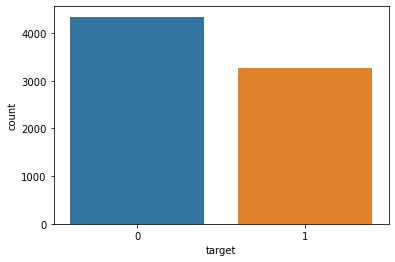

In [10]:
sns.countplot(train_set['target'])

In [11]:
mod_1 = train_set['keyword'].mode()
train_set['keyword'].fillna(mod_1[0], inplace=True)

In [12]:
mod_2 = train_set['location'].mode()
train_set['location'].fillna(mod_2[0],inplace=True)

In [13]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [14]:
train_set.head()

,id,keyword,location,text,target
0,1,fatalities,USA,Our Deeds are the Reason of this #earthquake M...,1
1,4,fatalities,USA,Forest fire near La Ronge Sask. Canada,1
2,5,fatalities,USA,All residents asked to 'shelter in place' are ...,1
3,6,fatalities,USA,"13,000 people receive #wildfires evacuation or...",1
4,7,fatalities,USA,Just got sent this photo from Ruby #Alaska as ...,1


In [15]:
train_set.drop(['id'],axis=1,inplace=True)

In [16]:
train_X = train_set.iloc[:,:-1]
train_y = train_set.iloc[:,-1]
train_X

,keyword,location,text
0,fatalities,USA,Our Deeds are the Reason of this #earthquake M...
1,fatalities,USA,Forest fire near La Ronge Sask. Canada
2,fatalities,USA,All residents asked to 'shelter in place' are ...
3,fatalities,USA,"13,000 people receive #wildfires evacuation or..."
4,fatalities,USA,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...
7608,fatalities,USA,Two giant cranes holding a bridge collapse int...
7609,fatalities,USA,@aria_ahrary @TheTawniest The out of control w...
7610,fatalities,USA,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,fatalities,USA,Police investigating after an e-bike collided ...


In [17]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [19]:
for i in train_X['text']: # print Each line in text column to know what i will clear
    x = i.split()
#     print(x)

In [20]:
def clean_text(text):
    text=text.lower()

    text=re.sub("\W"," ",text)
    text=re.sub(r"i'm","i am",text)
    text=re.sub(r"There's","There is",text)
    text=re.sub('[0-9]'," ",text)
    text=re.sub('http+'," ",text)
    text=re.sub("can't","cannot",text)
    text=re.sub("n't","not",text)  
    text=re.sub("cuz","becuse",text)
    text='<BOS> '+text+' <EOS>'
    return text

In [21]:
result = []
for line in train_X['text']:
    line = clean_text(line)
    line = line.split()
    for word in line:
        ps=PorterStemmer()
        line=[ps.stem(word) for word in line]
    result.append(line)    
print(result[0])

['<bos>', 'our', 'deed', 'are', 'the', 'reason', 'of', 'thi', 'earthquak', 'may', 'allah', 'forgiv', 'us', 'all', '<eos>']


In [22]:
token = Tokenizer(num_words=400)
word_token = token.texts_to_sequences(result)
padded_sequence = pad_sequences(word_token,maxlen=30)

In [23]:
print(padded_sequence)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [24]:
Train_X = pd.DataFrame(padded_sequence)
Train_X

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
Train_X["keyword"] = train_X['keyword'].values
Train_X['location'] = train_X['location'].values

In [26]:
Train_X

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,keyword,location
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,fatalities,USA
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,fatalities,USA
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,fatalities,USA
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,fatalities,USA
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,fatalities,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,fatalities,USA
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,fatalities,USA
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,fatalities,USA
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,fatalities,USA


In [27]:
le=LabelEncoder()
le.fit_transform(Train_X['keyword'])
Train_X['keyword']=le.fit_transform(Train_X['keyword'])

In [28]:
le.fit_transform(Train_X['location'])
Train_X['location']=le.fit_transform(Train_X['location'])

In [29]:
Train_X

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,keyword,location
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104,2643
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104,2643
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104,2643
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104,2643
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104,2643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104,2643
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104,2643
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104,2643
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104,2643


In [30]:
model = tensorflow.keras.Sequential()
model.add(Embedding(5000, 64, input_length=32))
model.add(LSTM(150, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 64)            320000    
                                                                 
 lstm (LSTM)                 (None, 32, 150)           129000    
                                                                 
 global_average_pooling1d (G  (None, 150)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 150)               22650     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                        

In [31]:
history = model.fit(Train_X, train_y, batch_size=150, epochs=10, validation_split=0.25)

Epoch 1/10
39/39 [==============================] - 8s 148ms/step - loss: 0.6840 - accuracy: 0.5738 - val_loss: 0.6905 - val_accuracy: 0.5494
Epoch 2/10
39/39 [==============================] - 5s 128ms/step - loss: 0.6816 - accuracy: 0.5773 - val_loss: 0.6893 - val_accuracy: 0.5494
Epoch 3/10
39/39 [==============================] - 5s 128ms/step - loss: 0.6813 - accuracy: 0.5773 - val_loss: 0.6886 - val_accuracy: 0.5494
Epoch 4/10
39/39 [==============================] - 5s 126ms/step - loss: 0.6779 - accuracy: 0.5773 - val_loss: 0.6897 - val_accuracy: 0.5494
Epoch 5/10
39/39 [==============================] - 5s 125ms/step - loss: 0.6626 - accuracy: 0.5913 - val_loss: 0.6895 - val_accuracy: 0.5693
Epoch 6/10
39/39 [==============================] - 5s 129ms/step - loss: 0.5740 - accuracy: 0.7183 - val_loss: 0.8696 - val_accuracy: 0.5525
Epoch 7/10
39/39 [==============================] - 5s 127ms/step - loss: 0.5106 - accuracy: 0.7527 - val_loss: 0.7337 - val_accuracy: 0.4984
Epoch 

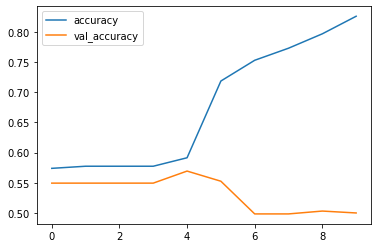

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

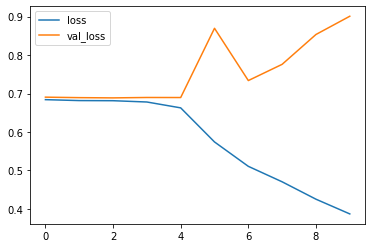

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [34]:
mod_11 = test_set['keyword'].mode()
test_set['keyword'].fillna(mod_11[0], inplace=True)

In [35]:
mod_22 = test_set['location'].mode()
test_set['location'].fillna(mod_22[0],inplace=True)

In [36]:
test_set.head()

,id,keyword,location,text
0,0,deluged,New York,Just happened a terrible car crash
1,2,deluged,New York,"Heard about #earthquake is different cities, s..."
2,3,deluged,New York,"there is a forest fire at spot pond, geese are..."
3,9,deluged,New York,Apocalypse lighting. #Spokane #wildfires
4,11,deluged,New York,Typhoon Soudelor kills 28 in China and Taiwan


In [37]:
test_result = []
for line in test_set['text']:
    line = clean_text(line)
    line = line.split()
    for word in line:
        ps=PorterStemmer()
        line=[ps.stem(word) for word in line]  
    test_result.append(line)  
test_result[0]

['<bos>', 'just', 'happen', 'a', 'terribl', 'car', 'crash', '<eos>']

In [38]:
word_token_test = token.texts_to_sequences(test_result)
padded_seq = pad_sequences(word_token_test,maxlen=30)

In [39]:
test_y=pd.DataFrame(padded_seq)
test_y

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
test_y["keyword"] = test_set['keyword'].values
test_y['location'] = test_set['location'].values

In [41]:
le.fit_transform(test_y['keyword'])
test_y['keyword']=le.fit_transform(test_y['keyword'])

In [42]:
le.fit_transform(test_y['location'])
test_y['location']=le.fit_transform(test_y['location'])

In [43]:
test_y.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,keyword,location
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64,858
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64,858
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64,858
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64,858
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64,858


In [44]:
y_pred = model.predict(test_y)

In [45]:
y_pred

array([[0.5498586],
       [0.5498586],
       [0.5498586],
       ...,
       [0.5498586],
       [0.5498586],
       [0.5498586]], dtype=float32)